In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import joblib

# Load dataset

In [37]:
df = pd.read_csv('creditcard.csv')
print("Data loaded. Shape:", df.shape)
df.head()

Data loaded. Shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [57]:
pd.set_option('display.max_columns', None)
df[df['Class'] ==1].head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,3.202033,-2.899907,-0.595222,-4.289254,0.389724,-1.140747,-2.830056,-0.016822,0.416956,0.126911,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,-0.838587,-0.414575,-0.503141,0.676502,-1.692029,2.000635,0.666780,0.599717,1.725321,0.283345,2.102339,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,2.032912,-6.560124,0.022937,-1.470102,-0.698826,-2.282194,-4.781831,-2.615665,-1.334441,-0.430022,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,-4.801637,4.895844,-10.912819,0.184372,-6.771097,-0.007326,-7.358083,-12.598419,-5.131549,0.308334,-0.171608,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,-2.447469,2.101344,-4.609628,1.464378,-6.079337,-0.339237,2.581851,6.739384,3.042493,-2.721853,0.009061,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1


# Exploratory Data Analysis

In [38]:
# Check class distribution
print("Class distribution:")
print(df['Class'].value_counts())

Class distribution:
Class
0    284315
1       492
Name: count, dtype: int64


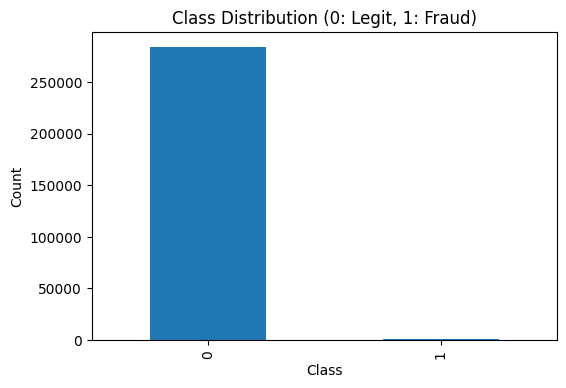

In [39]:
# Plot class distribution
plt.figure(figsize=(6,4))
df['Class'].value_counts().plot(kind='bar')
plt.title('Class Distribution (0: Legit, 1: Fraud)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Preprocessing and Scaling

In [40]:
X = df.drop(['Class', 'Time'], axis=1)
y = df['Class']

In [41]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [42]:
# Train/test split (stratify to keep class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Train set shape: (199364, 29)
Test set shape: (85443, 29)


# Balancing the Training Data with SMOTE

In [43]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("After SMOTE, training set class distribution:")
print(pd.Series(y_train_res).value_counts())

After SMOTE, training set class distribution:
Class
0    199020
1    199020
Name: count, dtype: int64


# Unsupervised Anomaly Detection

In [44]:
# Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
y_pred_iso = iso_forest.fit_predict(X_test)

# Convert to 0 (not fraud) / 1 (fraud)
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)
print("Isolation Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_iso))

# Local Outlier Factor (LOF)
lof = LocalOutlierFactor(n_neighbors=50, contamination=0.01)
y_pred_lof = lof.fit_predict(X_test)
y_pred_lof = np.where(y_pred_lof == -1, 1, 0)
print("LOF Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lof))

Isolation Forest Confusion Matrix:
[[84512   783]
 [   76    72]]
LOF Confusion Matrix:
[[84450   845]
 [  138    10]]


# Supervised Classification with XGBoost

In [45]:
# scale_pos_weight compensates for class imbalance
xgb = XGBClassifier(eval_metric='logloss', scale_pos_weight=99, random_state=42)
xgb.fit(X_train_res, y_train_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [46]:
# Predictions
y_pred_xgb = xgb.predict(X_test)
y_pred_xgb_proba = xgb.predict_proba(X_test)[:,1]

print("XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

XGBoost Confusion Matrix:
[[85217    78]
 [   24   124]]
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.61      0.84      0.71       148

    accuracy                           1.00     85443
   macro avg       0.81      0.92      0.85     85443
weighted avg       1.00      1.00      1.00     85443



# ROC Curve Plot

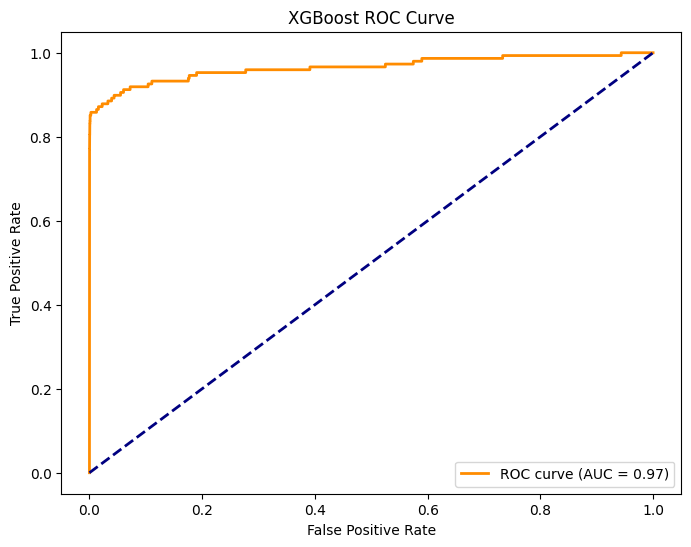

In [47]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_xgb_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix Plot

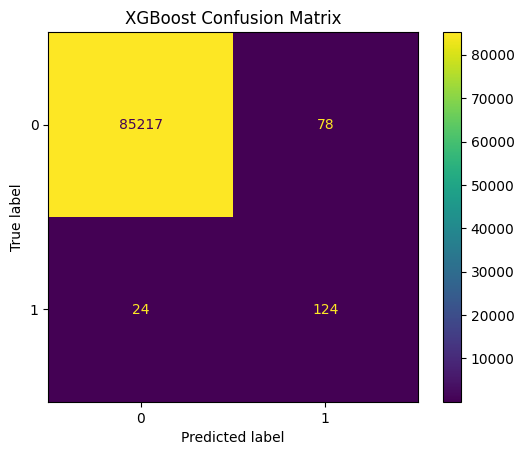

In [48]:
ConfusionMatrixDisplay.from_estimator(xgb, X_test, y_test)
plt.title("XGBoost Confusion Matrix")
plt.show()

# Save Model and Scaler

In [49]:
joblib.dump(xgb, 'xgb_model.joblib')
joblib.dump(scaler, 'scaler.joblib')

print("Model and scaler saved for deployment.")

Model and scaler saved for deployment.
